In [1]:
import rasterio as rio
from rasterio import warp
import numpy as np
import matplotlib.pyplot as plt

from rasterio.windows import Window
from rasterio.transform import Affine

from shapely.geometry import box

In [2]:
import os
import matplotlib.patches as mpatches
import ast

In [3]:
rgb_path = "satellite/rgb/"
scl_path = "satellite/classifications/"
rgb_files = os.listdir(rgb_path)
scl_files = os.listdir(scl_path)

In [4]:
rgb_files

['T32UMF_20170619T103021_TCI_10m.jp2',
 'T32UMG_20170829T105019_TCI_10m.jp2',
 'T32UNG_20170823T103019_TCI_10m.jp2',
 'T32UPF_20170619T103021_TCI_10m.jp2',
 'T32UPF_20170709T103021_TCI_10m.jp2',
 'T32UPF_20170823T103019_TCI_10m.jp2',
 'T32UPG_20170527T102031_TCI_10m.jp2',
 'T32UPG_20170823T103019_TCI_10m.jp2',
 'T32VNH_20170823T103019_TCI_10m.jp2',
 'T32VNJ_20170823T103019_TCI_10m.jp2',
 'T32VPH_20170823T103019_TCI_10m.jp2',
 'T33UUB_20170527T102031_TCI_10m.jp2',
 'T33UUB_20170619T103021_TCI_10m.jp2']

In [5]:
labels = ["no data", "saturated or defective","dark_area_pixels", "cloud_shadows", "vegetation","not vegetated","water", "unclassified","cloud medium probability","cloud medium probability","thin cirrus", "snow"]
labels = [f"{i} {labels[i]}" for i in range(len(labels))]

In [6]:
# align classfication data to rgb data because of different spatial resolution
def align(src, dst, src_arr, dst_arr):
    src_new = np.repeat(np.zeros_like(dst_arr[[0]]), src.count, 0)
    warp.reproject(
        src_arr, src_new, 
        src_crs=src.crs, dst_crs=dst.crs,
        src_transform=src.transform, dst_transform=dst.transform,
        dst_resolution=dst.res,
        resampling=warp.Resampling.nearest
    )
    return src_new

In [7]:
lc = rio.open("denmark_landcover.tif")

In [8]:
def get_scl_rgb_lc(idx):
    rgb = rio.open(rgb_path + rgb_files[idx])
    scl = rio.open(scl_path + scl_files[idx])
    
    rgb_r = rgb.read()
    scl_a = align(scl, rgb, scl.read(), rgb_r)
    lc_a = align(lc, rgb, lc.read(), rgb_r)
    scl.close()
    rgb.close()
    return scl_a, rgb_r, lc_a

In [9]:
lc_labels = {
    str([255, 255, 255, 255]):"Clouds",
    str([210,0,0,255]):"Artificial surfaces and constructions",
    str([253,211,39,255]):"Cultivated areas",
    str([176,91,16,255]):"Vineyards",
    str([35,152,0,255]):"Broadleaf tree cover",
    str([8,98,0,255]):"Coniferous tree cover",
    str([249,150,39,255]):"Herbaceous vegetation",
    str([141,139,0,255]):"Moors and Heathland",
    str([95,53,6,255]):"Sclerophyllous vegetation",
    str([149,107,196,255]):"Marshes",
    str([77,37,106,255]):"Peatbogs",
    str([154,154,154,255]):"Natural material surfaces",
    str([106,255,255,255]):"Permanent snow covered surfaces",
    str([20,69,249,255]):"Water bodies",
    str([255,255,255,255]):"No data",
}

In [10]:
# see what labels are in this landcover
#lc_s = np.vstack(np.transpose(lc_a))
#u = np.unique(lc_s,axis=0)
#u
#for i in u:
#    print(lc_labels[str(list(i))])

In [11]:
labels

['0 no data',
 '1 saturated or defective',
 '2 dark_area_pixels',
 '3 cloud_shadows',
 '4 vegetation',
 '5 not vegetated',
 '6 water',
 '7 unclassified',
 '8 cloud medium probability',
 '9 cloud medium probability',
 '10 thin cirrus',
 '11 snow']

In [12]:
water = 6
cloud = [3,8,9]
invalid = [0, 1, 2]
def is_lc_valid(scl):
    classes = scl.flatten()
    n = scl.shape[0] * scl.shape[1]
    
    if n * .4 < classes[classes == water].size:
        # too much water
      #  print("too much water")
        return False
    # if more than 5% clouds or no data
    for c in cloud:
        if classes[classes == c].size > n*0.05:
            # If contains clouds
          #  print("Contains clouds")
            return False
    
    for c in invalid:
        if classes[classes == c].size > n*0.05:
            # If contains clouds
           # print("Contains invalid")
            return False
        
    return True

In [13]:
def plot_lc_hist(lc_256):
    a = np.vstack(np.transpose(lc_256))
    d = {}
    for i in a:
        l = str(list(i))
        if l not in d:
            d[l] = 0
        d[l] += 1

    labs = []
    for l in d.keys():
        labs.append(lc_labels[l])

    plt.bar(labs, d.values())
    plt.xticks(rotation = "vertical")

In [14]:
def plot_scl_hist(scl_256):
    a = scl_256.flatten()
    d = {}
    for i in a:
        # l = str(list(i))

        l = i
        if l not in d:
            d[l] = 0
        d[l] += 1
    labs = []
    for l in d.keys():
        labs.append(labels[l])

    plt.bar(labs, d.values())
    plt.xticks(rotation = "vertical")

In [15]:
def print_all(scl_256, rgb_256, lc_256,root_dir):
    cmap = plt.get_cmap("viridis")
    fig, ax = plt.subplots(1,3, figsize=(12,16))
    ax[0].imshow(np.moveaxis(lc_256, 0, -1))
    ax[0].set_title("lc")
    ax[1].imshow(np.moveaxis(rgb_256, 0, -1))
    ax[1].set_title("rgb")
    ax[2].imshow(scl_256/11, cmap=cmap)
    ax[2].set_title("scl")

    patches = [mpatches.Patch(color=np.array(ast.literal_eval(i))/255, label=lc_labels[i]) for i in lc_labels]
    l1 = plt.legend(handles=patches, loc="best",bbox_to_anchor=(-.3,-.3,1,.1), ncol=3, title="lc labels")


    patches2 = [mpatches.Patch(color=cmap(i/11), label=labels[i]) for i in range(len(labels))]
    l2 = plt.legend(handles=patches2, loc="best",bbox_to_anchor=(0,1.5,1,.1), ncol=3, title="scl labels")
    plt.gca().add_artist(l1)

    fn = rgb_files[idx].split("_")

    
    fn = f"{root_dir}/all/{fn[0]}_{fn[1]}_{w}_{h}.png"
    
    plt.savefig(fn)
    plt.close("all")

In [16]:
def save_imgs(scl_256, rgb_256, lc_256, root_dir):
    if not is_lc_valid(scl_256):
        return False
    fn = rgb_files[idx].split("_")
    fn = f"{fn[0]}_{fn[1]}"
    pathname = f"{fn}_{w}_{h}.png"
    scl_fn = f"{root_dir}/scl/{pathname}"
    lc_fn = f"{root_dir}/lc/{pathname}"
    rgb_fn = f"{root_dir}/rgb/{pathname}"

    plt.imsave(scl_fn, scl_256)
    lc_256 = np.ascontiguousarray(np.moveaxis(lc_256, 0, -1))

    rgb_256 = np.ascontiguousarray(np.moveaxis(rgb_256, 0, -1))

    plt.imsave(lc_fn, lc_256)
    plt.imsave(rgb_fn, rgb_256)
    return True

In [17]:
possible_dirs = ["train", "test", "val"]
possible_subdirs = ["rgb", "all", "lc","scl"]
for d in possible_dirs:
    if not os.path.exists(d):
        os.mkdir(d)
    for sd in possible_subdirs:
        full_sd = f"{d}/{sd}"
        if not os.path.exists(full_sd):
            os.mkdir(full_sd)

In [18]:
for idx in range(len(rgb_files)):
    print("idx",idx,end=" ")
    j=0
    # save 1000 samples
    if idx <= 10:
        root_dir = "train"
    elif idx == 11:
        root_dir = "val"
    elif idx == 12:
        root_dir = "test"
    scl_a, rgb_r, lc_a = get_scl_rgb_lc(idx)

    while j < 1000:

        w, h = np.random.randint(rgb_r.shape[2]-256), np.random.randint(rgb_r.shape[1]-256)
        w,h
        lc_256 = lc_a[:,h:h+256,w:w+256]
        rgb_256 = rgb_r[:,h:h+256,w:w+256]
        scl_256 = scl_a[0][h:h+256,w:w+256]

        if save_imgs(scl_256, rgb_256, lc_256,root_dir):
            if j%100 == 0:
                print("j",j, end=" ")
                print_all(scl_256, rgb_256, lc_256, root_dir)
            j+=1
    print()

idx 0 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 1 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 2 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 3 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 4 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 5 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 6 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 7 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 8 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 9 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 10 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 11 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 
idx 12 j 0 j 100 j 200 j 300 j 400 j 500 j 600 j 700 j 800 j 900 


In [19]:
lc_2562 = np.ascontiguousarray(np.moveaxis(lc_256, 0, -1))

In [20]:
lc_2562 = lc_2562[:,:,:3]
lc_2562.shape

(256, 256, 3)

In [21]:
h = 1952
w = 7524
lc_256 = lc_a[:,h:h+256,w:w+256]
rgb_256 = rgb_r[:,h:h+256,w:w+256]
scl_256 = scl_a[0][h:h+256,w:w+256]

#print(save_imgs(scl_256, rgb_256, lc_256, "train"))


#print_all(scl_256, rgb_256, lc_256,"train")

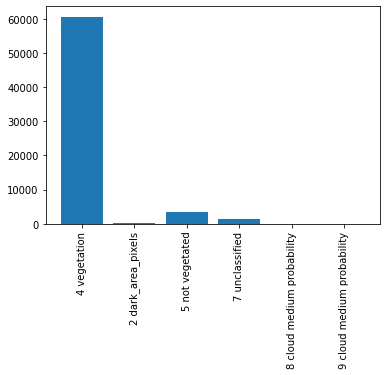

In [22]:
plot_scl_hist(scl_256)

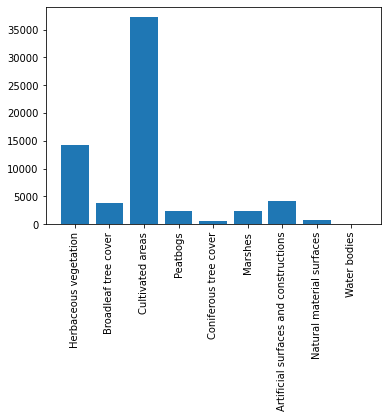

In [23]:
plot_lc_hist(lc_256)

In [24]:
t = plt.imread("val/rgb/T33UUB_20170527T102031_0_9719.png")

In [26]:
np.min(t), np.max(t)

(0.003921569, 1.0)